In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from rl_analysis.plotting import (
    setup_plotting_env,
    clean_ticks,
    savefig,
    clean_plot_labels
)
from rl_analysis.io.df import dlight_exclude
from joblib import Parallel, delayed

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

# Helper functions

In [3]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [4]:
raw_dirs = analysis_config["raw_data"]
proc_dirs = analysis_config["intermediate_results"]
dlight_cfg = analysis_config["dlight_common"]
regression_cfg = analysis_config["dlight_regression"]
lagged_cfg = analysis_config["dlight_lagged_correlations"]
figure_cfg = analysis_config["figures"]

In [5]:
file_suffix = "offline" if lagged_cfg["use_offline"] else "online"
load_file = os.path.join(raw_dirs["dlight"], f"dlight_snippets_{file_suffix}.parquet")

In [6]:
file, ext = os.path.splitext(load_file)
features_save_file = f"{file}_features{ext}"

if lagged_cfg["use_renormalized"]:
    file, ext = os.path.splitext(features_save_file)
    features_save_file = f"{file}_renormalize{ext}"

rle_save_file = features_save_file.replace("snippet", "usage")

In [7]:
use_features = []
for _use_win in lagged_cfg["use_windows"]:
    use_features += [f"{_}_{_use_win}" for _ in lagged_cfg["use_neural_features"]]
scalar_keys = lagged_cfg["usage_and_scalars"]["scalars"]

# Loading in features for correlation

In [8]:
use_area = "dls"

partition_cols = ["area", "mouse_id", "uuid"]
feature_df = pd.read_parquet(features_save_file)
feature_df[partition_cols] = feature_df[partition_cols].astype("str")
feature_df = feature_df.loc[
    (feature_df["duration"] > 0.3) & (feature_df["area"] == use_area)
].copy()
feature_df = dlight_exclude(
    feature_df, exclude_3s=False, syllable_key="syllable", **dlight_cfg
)

In [9]:
feature_df = feature_df.loc[
    feature_df["window"] == pd.Interval(0, 0.3, closed="both")
].copy()

In [10]:
use_features = ["signal_reref_dff_z_max", "velocity_2d_mm_mean"]

In [11]:
x_col = "centroid_x_mm_mean"
y_col = "centroid_y_mm_mean"
meta_cols = ["mouse_id", "uuid", "syllable"]

In [12]:
xy_col = [x_col, y_col]

## Via mutual information

In [13]:
ndlight_bins = 10
nposition_bins = 7

In [14]:
norm_by = ["uuid", "syllable"]
group_keys = ["syllable"]

In [15]:
xy_norm = feature_df.groupby("uuid")[xy_col].transform(
    lambda x: (x - x.quantile(0.025)) / (x.quantile(0.975) - x.quantile(0.025))
)
feature_norm = feature_df.groupby(norm_by)[use_features].transform(
    lambda x: (x - x.mean()) / x.std()
)

In [16]:
# cut each axis equivalently...
cuts = np.linspace(-0.25, 1.25, nposition_bins)

x_cuts = pd.cut(xy_norm[x_col], cuts, labels=False).rename("x_cuts")
y_cuts = pd.cut(xy_norm[y_col], cuts, labels=False).rename("y_cuts")

In [17]:
use_df = pd.concat(
    [xy_norm, x_cuts, y_cuts, feature_norm, feature_df[meta_cols]], axis=1
).dropna()
use_df["spatial_bin"] = (
    use_df.filter(regex="_cuts$").apply(tuple, axis=1).astype("category")
)

use_df["spatial_code"] = use_df["spatial_bin"].cat.codes
use_df[use_features] = use_df[use_features].transform(
    lambda x: pd.qcut(x, ndlight_bins, labels=False).astype("category")
)

In [18]:
from rl_analysis.info.util import dm_mi

In [19]:
mi = use_df.groupby(group_keys)[use_features].agg(
    lambda x: dm_mi(
        pd.crosstab(x, use_df["spatial_code"].loc[x.index]).values.astype("float"),
        alpha="perks",
    ),
)

In [20]:
def compute_shuffle_df(idx):
    shuffle_df = use_df.copy()
    shuffle_df["spatial_code"].values[:] = (
        shuffle_df.groupby(group_keys)["spatial_code"].sample(frac=1, random_state=idx).values
    )
    shuffle_mi = shuffle_df.groupby(group_keys)[use_features].agg(
        lambda x: dm_mi(
            pd.crosstab(x, shuffle_df["spatial_code"].loc[x.index]).values.astype(
                "float"
            ),
            alpha="perks",
        ),
    )
    shuffle_mi["idx"] = idx
    return shuffle_mi

In [21]:
nshuffles = 1000

In [22]:
delays = []
for i in range(nshuffles):
    delays.append(delayed(compute_shuffle_df)(i))

In [23]:
results = Parallel(n_jobs=-1, verbose=10)(delays)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 392 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 429 tasks      | elapsed: 

In [24]:
shuffle_df = pd.concat(results).set_index("idx", append=True)

In [25]:
shuffle_mu = shuffle_df.groupby(group_keys).mean()
shuffle_sig = shuffle_df.groupby(group_keys).std()

In [26]:
z_mi = (mi - shuffle_mu) / shuffle_sig
shuffle_z = (shuffle_df - shuffle_mu) / shuffle_sig

In [27]:
ci = shuffle_z.abs().quantile(0.95).max()

In [28]:
aliases = {"signal_reref_dff_z_max": "dLight peak", "velocity_2d_mm_mean": "velocity"}


In [29]:
setup_plotting_env()

In [30]:
pvals = (shuffle_z.groupby("idx").mean() > z_mi.mean()).mean()

In [31]:
pvals

signal_reref_dff_z_max    0.107
velocity_2d_mm_mean       0.000
dtype: float64

In [32]:
stat_dct = pvals.to_dict()
stat_dct["comparison_type"] = "shuffle test"
stat_dct["n"] = len(z_mi)
stat_dct["n_definition"] = "per syllable mutual information with position"

In [33]:
with open(
    os.path.join(
        proc_dirs["dlight"], f"dlight_position_mutual_information_{use_area}.toml"
    ),
    "w",
) as f:
    toml.dump(stat_dct, f)

In [34]:
len(z_mi)

57

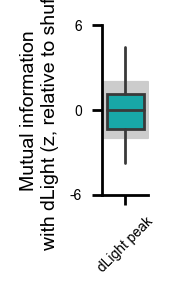

In [35]:
fig, ax = plt.subplots(1, figsize=(.3, 1.1))
sns.boxplot(
    data=z_mi.groupby("syllable").mean().melt(),
    x="variable",
    order=["signal_reref_dff_z_max"],
    showfliers=False,
    showcaps=False,
    color="c",
    y="value",
)
ax.fill_between(ax.get_xlim(), -ci, +ci, color=[0.8] * 3, zorder=-100)
plt.ylabel("Mutual information\nwith dLight (z, relative to shuffle)")
plt.xlabel("")
plt.ylim(-6, 6)
plt.xticks(rotation=45)
sns.despine()
clean_ticks(ax, "y", precision=0, dtype=int, zero_symmetry=False)
clean_plot_labels(ax, aliases)
savefig(
    fig,
    os.path.join(
        figure_cfg["store_dir"],
        f"dlight_position_analysis_mutual_information_{use_area}",
    ),
    bbox_inches="tight",
)

In [36]:
plt_bins = use_df.loc[(use_df["syllable"] == 20)][use_features + [x_col, y_col]].melt(
    id_vars=[x_col, y_col]
)

In [37]:
precision = 10
if use_area == "dls":
    binwidth = 0.075
else:
    binwidth = 0.125

In [38]:
vmax = np.quantile(
    np.histogram2d(
        plt_bins["centroid_x_mm_mean"],
        plt_bins["centroid_y_mm_mean"],
        np.arange(-1, 1, binwidth),
    )[0],
    0.8,
)
vmax /= precision
vmax = np.round(vmax) * precision

In [39]:
kwargs = {
    "vmin": 0,
    "vmax": vmax,
    "cmap": "rocket",
    "binwidth": binwidth,
}

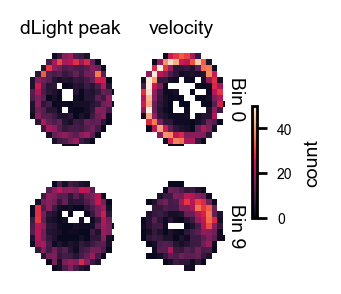

In [40]:
g = sns.displot(
    data=plt_bins,
    col="variable",
    row="value",
    row_order=[0, ndlight_bins - 1],
    x="centroid_x_mm_mean",
    y="centroid_y_mm_mean",
    height=0.9,
    aspect=1.1,
    kind="hist",
    facet_kws={"margin_titles": True, "sharex": True, "sharey": True},
    **kwargs,
)
g.set_axis_labels("", "")
g.set_titles(row_template="Bin {row_name}", col_template="{col_name}")
for _ax in g.axes.flat:
    _ax.axis("off")
    title_str = _ax.get_title()
    for k, v in aliases.items():
        title_str = title_str.replace(k, v)
    _ax.set_title(title_str)

cbar = g.fig.colorbar(
    g.axes.flat[0].collections[0],
    ax=g.axes.ravel().tolist(),
    shrink=0.5,
    pad=0.1,
    label="count",
)
cbar.set_ticks(np.arange(kwargs["vmin"], kwargs["vmax"] + 1, 20))
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
savefig(
    g.fig,
    os.path.join(
        figure_cfg["store_dir"], f"dlight_position_analysis_examplesyllable_{use_area}"
    ),
    bbox_inches="tight",
)

In [41]:
z_mi.to_parquet(
    os.path.join(proc_dirs["dlight"], f"position_mutual_information_{use_area}.parquet")
)

In [42]:
pvals

signal_reref_dff_z_max    0.107
velocity_2d_mm_mean       0.000
dtype: float64